**Praca domowa 4** \\
Michał Piasecki

In this work, I would like to analyse sensitivity of particular neural network.
Throughout this work, I will use architecture that I implemented in previous  
Let's start from a definition of 
**Sensitivity analysis of neural networks**

**Sensitivity analysis of neural networks** is a term, which describe how sensitive is particular neural network architecture for small distortions in data evaluated by a model or small changes in model parameters
We can change "environment" of model in three ways, after our model is trained we can:
1. Slightly change data, which model has to evaluate
2. Sligthly change parameters
3. Both change data and parameters

[Sensitivity Analysis of Deep Neural Networks Hai Shu, Hongtu Zhu 2019](https://arxiv.org/pdf/1901.07152.pdf)


As a reminder, our model works on CIFAR-10 data, which is set of labeled images divided into 10 categories. Here we will do the same thing like in previous notebook, mainly loading dataset, displaying examples in each category, build and train our model

## Packages

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(2020) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import clone_model
from numpy.random import seed
import copy
import skimage
from skimage.util import random_noise
from sklearn.metrics import classification_report
np.random.seed(20)




In [ ]:
## Additional functions

In [ ]:
def plotting_model(model_info):
  table = pd.DataFrame.from_dict(model_info.history)
  table.reset_index(inplace = True)
  plt.figure(figsize = (20,10))
  plt.plot(table['index'],table['accuracy'], color = 'skyblue', label = 'accuracy')
  plt.plot(table['index'],table['val_accuracy'], color = 'orange', label = 'test accuracy')
  plt.grid(alpha = 0.2)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(prop={'size': 20})
  plt.show()


def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)


## Loading Data

In [ ]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols, img_channels =  train_features.shape
num_test  =  test_features.shape[0]
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 11s 0us/step


## Displaying examples in each category

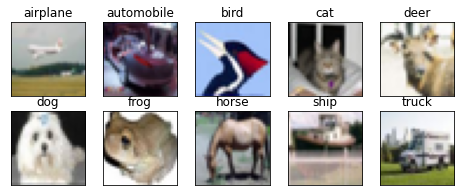

In [ ]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Preprocessing

In [ ]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

## Building model

In [ ]:
model_basic = Sequential()
model_basic.add(Convolution2D(48, (3, 3),activation='relu', input_shape=(32, 32,3)))
model_basic.add(MaxPooling2D((2, 2)))
model_basic.add(Dropout(0.25))
model_basic.add(Convolution2D(96, (3, 3),activation='relu'))
model_basic.add(MaxPooling2D((2, 2)))
model_basic.add(Dropout(0.25))
model_basic.add(Convolution2D(192, (3, 3),activation='relu'))
model_basic.add(MaxPooling2D((2, 2)))
model_basic.add(Dropout(0.25))
model_basic.add(Flatten())
model_basic.add(Dense(512, activation = 'relu'))
model_basic.add(Dropout(0.5))
model_basic.add(Dense(256,activation = 'relu'))
model_basic.add(Dropout(0.5))
model_basic.add(Dense(num_classes, activation='softmax'))
model_basic.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


## Training model

In [ ]:
model_basic.fit(x = train_features, y = train_labels, validation_split= 0.1, batch_size = 64, steps_per_epoch= 100, epochs= 200, verbose = 0)

In [ ]:
results = model_basic.predict(test_features)
results
##classification_report(test_labels, results)

array([[4.9781594e-03, 4.0389848e-04, 7.8840777e-03, ..., 4.6730973e-03,
        3.7118797e-03, 6.3371460e-04],
       [5.0453871e-04, 9.2758480e-03, 1.3411703e-07, ..., 2.0997417e-09,
        9.8985273e-01, 3.6652014e-04],
       [4.4596609e-02, 2.6804620e-02, 2.7003435e-03, ..., 2.4512329e-04,
        8.6575305e-01, 5.6405060e-02],
       ...,
       [1.2575545e-06, 5.7692597e-09, 4.7977394e-03, ..., 2.2124477e-02,
        1.6804995e-07, 1.5973372e-06],
       [2.5468325e-02, 8.3197767e-01, 6.7019099e-03, ..., 1.2387206e-03,
        8.9984009e-04, 3.6345884e-02],
       [7.5369357e-11, 5.6256316e-15, 4.4433855e-05, ..., 9.6676677e-01,
        2.2052416e-14, 3.5790678e-12]], dtype=float32)

# Changing data
## Adding Gaussian Noise to data

As a first experiment, we will change our test data, adding a white noise (Gaussian noise) to every picture. We will add four different layers of noise, which will differ from value of variance of gaussian noise. With every layer we will see if there are any differences for human vision on 3 examples and then see how our model works on changed data

In [ ]:

def add_gaussian_noise(images, variance_parameter,i):
  new_images = copy.deepcopy(images)
  for i in range(images.shape[0]):
    new_images[i,::] = random_noise(image = new_images[i,::], mode= 'gaussian', seed = i, var = variance_parameter,)    
  return new_images 
def show_few_examples(new_images_1, new_images_2, new_images_3, images):
  for i in range(2):
    image_index = np.random.randint(low = 0, high = new_images_1.shape[0])
    plt.figure(figsize=(2,2))
    plt.title("Normal picture")
    plt.imshow(test_features[image_index,::])
    plt.figure(figsize=(2,2))
    plt.title(f"+ Gaussian Noise 0.001")
    plt.imshow(new_images_1[image_index,::])
    plt.figure(figsize=(2,2))
    plt.title(f"+ Gaussian Noise 0.005")
    plt.imshow(new_images_2[image_index,::])
    plt.figure(figsize=(2,2))
    plt.title(f"+ Gaussian Noise 0.01")
    plt.imshow(new_images_3[image_index,::])
     

 

In [ ]:

images_after_gaussian_noise = [add_gaussian_noise(test_features,0.001,1), add_gaussian_noise(test_features,0.005,1), add_gaussian_noise(test_features,0.01,1)]

## Gaussian noise - examples

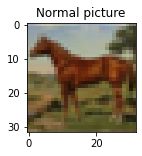

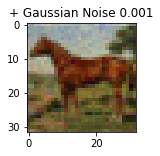

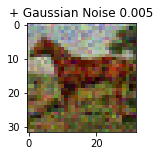

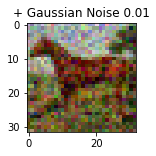

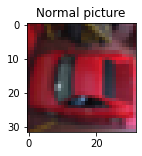

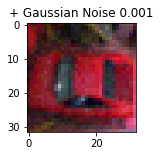

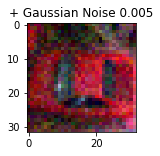

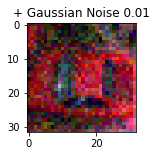

In [ ]:
show_few_examples(images_after_gaussian_noise[0],images_after_gaussian_noise[1],images_after_gaussian_noise[2],test_features)

We can see that with Gaussian Noise with variance 0.001 there is barely any difference between normal photo and changed one (at least I am not able to spot it). When it comes to higher variances the differences start to be noticeable.
Let's see how our model work on them

In [ ]:
values = [0.001, 0.005, 0.01]
print("Without noise")
print(accuracy(test_features,test_labels, model_basic))
for i in range(len(images_after_gaussian_noise)):
  print("Gaussian noise " + str(values[i]))
  print(accuracy(images_after_gaussian_noise[i], test_labels, model_basic))

Without noise
76.19
Gaussian noise 0.001
73.4
Gaussian noise 0.005
59.89
Gaussian noise 0.01
47.13


Now we will play few models on Gaussian Noise 0.005 and see standard deviation

In [ ]:
values = np.zeros(5)
for i in range(5):
  new_images = add_gaussian_noise(test_features, 0.005, i)
  values[i] = accuracy(new_images, test_labels, model_basic)
print(values)
print(np.std(values))

[59.89 59.89 59.89 59.89 59.89]
0.0


we can see that there is not much difference if we add very small noise (variance 0.001). Nevertheless, when we start to distort our images to higher extent our model starts to work poorely.

## Changing random 20 pixels
Now, we will change randomly n pixels in our images and see how our model will cope with this. I will add to every chosen pixel 1. We will se how many pixels needs to be changed to result in accuracy smaller than 50 %. Iteration step will be 5 pixels

In [ ]:
def perturbation_in_images(images, n_pixels):
    ## choosing n pixels
    new_images = copy.deepcopy(images)
    counter = 0
    for image in images:
      new_image = copy.deepcopy(image)
      for k in range(n_pixels):
          i = np.random.randint(0,32)
          j = np.random.randint(0,32)
          s = np.random.randint(0,3)
          new_image[i,j,s] = image[i,j,s] + np.random.randint(low = 1, high = 2)
      new_images[counter, ::] = new_image
      counter = counter + 1
    return new_images
def how_many_pixels(images):
  actual_accuracy= accuracy(test_features, test_labels, model_basic)
  n_pixels = 0
  while(actual_accuracy > 50):
      print(f"Pictures with {n_pixels} pixels changed")
      print("Accuracy " + str(actual_accuracy))
      n_pixels = n_pixels + 5
      new_features = perturbation_in_images(test_features, n_pixels)
      actual_accuracy = accuracy(new_features, test_labels, model_basic)



In [ ]:
how_many_pixels(test_features)

We can see that we could change up to 60 pixels. Our images are of size 3x26x26 which is 2028 pixels, so we could change around 5 % percent of pixels.
Obviously human eye cannot spot any difference between such photos.

In [ ]:
changed_photos_60 = perturbation_in_images(test_features, 60)
plt.figure(figsize= (2,2))
plt.title("normal foto")
plt.imshow(test_features[0])
plt.figure(figsize=(2,2))
plt.title("60 pix changed")
plt.imshow(changed_photos_60[0])


What? Ups I wrote it before I saw this photos and it turned out to be complete rubbish :D To be honest I don't really understand it why these photos are so different if I changed pixels by value 1. I thought that having range (0,256) changing value by 1 does not make any difference. Maybe my algorithm is incorrect? Unfortunately I have no time to explore it :(

Unfortunately I had no time to explore how my model would change if I made changes into model layers :(
  Once again :) 

# Changing layers 
## Adding  Noise to  all layers
The idea is simple: to each weight in a layer we add or substract x % percent of weight value where x is in range [-maximum_percentage, maximum_percentage] and is chosen randomly for each weight

Now, we will add noise to all convolutional and dense layers with different values.

In [ ]:
def changing_layers(model, list_of_layers, maximum_percentage):
  ## function to change weights in layers 
  new_model = clone_model(model)
  for index in list_of_layers:
    # taking weights for particular layer
    weights = model_basic.layers[index].get_weights()[0]
    # generating number for each weigth in layer with range [-maximum_percentage/100, maximum_percentage/100]
    random_numbers = (np.random.randint(low = - maximum_percentage, high = maximum_percentage + 1, size = weights.shape)) / 100
    # updating weights
    weights = weights + weights * random_numbers
    new_model.layers[index].set_weights([weights, new_model.layers[index].get_weights()[1]])  
  return new_model


In [ ]:
print("Models with changed both convolutional and dense layers")
layers = [0,3,6,10,12]
percentages = [1,3,5,10]
models_new = []
print("Normal results")
print(accuracy(test_features, test_labels, model_basic))
for i in range(4):
  models_new.append(changing_layers(model_basic, layers, percentages[i]))
  print(f"Result with change in range: [{-percentages[i]}, {percentages[i]}]")
  print(accuracy(test_features,test_labels, models_new[i]))


Models with changed both convolutional and dense layers
Normal results
75.42
Result with change in range: [-1, 1]
12.65
Result with change in range: [-3, 3]
14.829999999999998
Result with change in range: [-5, 5]
6.890000000000001
Result with change in range: [-10, 10]
17.87


In [ ]:
# Just checking that generating random weights was implemented correctly
weights = model_basic.layers[0].get_weights()[0]
    # generating number for each weigth in layer with range [-maximum_percentage/100, maximum_percentage/100]
random_numbers = (np.random.randint(low = - 1, high = 1, size = weights.shape)) / 100
new_weights = weights + weights * random_numbers
print(np.sum(np.absolute(new_weights)))
print(np.sum(np.absolute(weights)))

134.2901662934001
134.96552


Wow, the results are just terrible! What is strange is that even if we manipulate our weights within range [-1,1] our model is a rubbish. So it doesn't matter if we change our model by 1 percent or 10 percent. Actually the best results are with range [-10,10], but the result is still so poor that there is no difference between them

## Changing only convolutional layers
Now, we will change only convolutional layers and see if it helps

In [ ]:
print("Models with changed only convolutional layers")
layers = [0,3,6]
percentages = [1,3,5,10]
models_new = []
print("Normal results")
print(accuracy(test_features, test_labels, model_basic))
for i in range(4):
  models_new.append(changing_layers(model_basic, layers, percentages [i]))
  print(f"Result with percentage range: {percentages[i]}")
  print(accuracy(test_features,test_labels, models_new[i]))


Models with changed only convolutional layers
Normal results
75.42
Result with percentage range: 1
8.38
Result with percentage range: 3
9.56
Result with percentage range: 5
9.34
Result with percentage range: 10
8.540000000000001


Okay, they did not improve at all :( Maybe only convolutional layers are important and small changes in dense layers will not cause so much harm?

In [ ]:
print("Models with changed both convolutional and dense layers")
layers = [10,12]
percentages = [1, 3, 5, 10]
models_new = []
print("Normal results")
print(accuracy(test_features, test_labels, model_basic))
for i in range(4):
  models_new.append(changing_layers(model_basic, layers, variances[i]))
  print(f"Result with range percentage: {percentages[i]}")
  print(accuracy(test_features,test_labels, models_new[i]))


Models with changed both convolutional and dense layers
Normal results
75.42
Result with range percentage: 1
9.33
Result with range percentage: 3
10.0
Result with range percentage: 5
10.99
Result with range percentage: 10
9.85


Have I implemented this noise incorrectly or should it really perform so poorly? It seems like changing any set of layers turns our model into rubbish.
At the end let's see if I change only one convolutional layer

In [ ]:
single_layers = [[0], [3], [6]]
percentages = [1, 3, 5, 10]
print("Normal results")
print(accuracy(test_features, test_labels, model_basic))
for i in range(3):
  print(f"Results with changed {i + 1} convolutional layer")
  for j in range(4):
    print(f"Range: {percentages[j]}")
    new_model = changing_layers(model_basic, single_layers[i], variances[j])
    print(accuracy(test_features, test_labels, new_model))



Normal results
75.42
Results with changed 1 convolutional layer
Range: 1
9.51
Range: 3
11.73
Range: 5
10.870000000000001
Range: 10
10.39
Results with changed 2 convolutional layer
Range: 1
10.91
Range: 3
8.73
Range: 5
9.99
Range: 10
9.64
Results with changed 3 convolutional layer
Range: 1
10.26
Range: 3
11.219999999999999
Range: 5
10.54
Range: 10
9.42


These results are surprising to me. From my analysis it seems that changing even one layers makes our model useless and it actually does not matter if I change one or many layers. Such results are counterintuitive to me. 
At the end I will check even smaller changes like 0.01 % or 0.001 %

In [ ]:
single_layers = [[0], [3], [6]]
percentages = [0.01, 0.001]
print("Normal results")
print(accuracy(test_features, test_labels, model_basic))
for i in range(3):
  print(f"Results with changed {i + 1} convolutional layer")
  for j in range(2):
    print(f"Range: {percentages[j]}")
    new_model = changing_layers(model_basic, single_layers[i], variances[j])
    print(accuracy(test_features, test_labels, new_model))



Normal results
75.42
Results with changed 1 convolutional layer
Range: 0.01
8.73
Range: 0.001
9.99
Results with changed 2 convolutional layer
Range: 0.01
10.0
Range: 0.001
9.049999999999999
Results with changed 3 convolutional layer
Range: 0.01
9.78
Range: 0.001
10.26


It is strange. I think I have done something incorrectly so I would love to get informed what is incorrect in my analysis